In [2]:
import scipy.stats as st
import pandas as pd 
import seaborn as sns
from pylab import mpl 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
import warnings

warnings.filterwarnings('ignore')
# plt.rcParams['font.sans-serif'] = ['STSong']
# mpl.rcParams['font.sans-serif'] = ['STSong'] # 指定默认字体 
mpl.rcParams['axes.unicode_minus'] = False


/Applications/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
df4 = pd.read_csv('./data/file4.csv')

df5 = pd.read_csv('./data/file5.csv')


# 将最新的定价作为price 和提取降价次数、幅度特征

In [4]:
# 将最后一次调整价格的时间，作为pushDate，最新的价格作为pushPrice
def clear_time(txt_json):
    if txt_json == '{}':
        return np.nan
    else:
        update_time = txt_json[2:-2].split(',')[-1].split(':')[0].strip()[2:-2]
        update_price = txt_json[2:-
                                2].split(',')[-1].split(':')[1].strip()[2:-2]
        barging_times = len(txt_json[2:-2].split(','))
        new_str = update_time+','+update_price+','+str(barging_times)
        return new_str
# 对file4进行处理

df4['updatePriceTimeJson'] = df4['updatePriceTimeJson'].progress_apply(
    clear_time)
sep = df4['updatePriceTimeJson'].astype(str).str.split(',', expand=True)
df4['update_time'] = sep[0].astype(str)
df4['update_price'] = sep[1].astype(float)
df4['update_price'] = df4['update_price'].fillna(0)

# 提取降价次数特征
df4['barging_times'] = sep[2].astype(float)
# 提取降价幅度特征
df4['barging_price'] = np.nan
for i in range(df4.shape[0]):
    update_time = df4['update_time'][i]
    update_price = df4['update_price'][i]
    if update_price == 0:
        df4['barging_price'][i] = 0
    else:
        df4['barging_price'][i] = df4['pushPrice'][i]-update_price
        df4['pushDate'][i] = update_time
        df4['pushPrice'][i] = update_price


100%|██████████| 10000/10000 [00:00<00:00, 325510.78it/s]


In [5]:
# 对file5 进行处理
df5['updatePriceTimeJson'] = df5['updatePriceTimeJson'].progress_apply(
    clear_time)
sep = df5['updatePriceTimeJson'].astype(str).str.split(',', expand=True)
df5['update_time'] = sep[0].astype(str)
df5['update_price'] = sep[1].astype(float)
df5['update_price'] = df5['update_price'].fillna(0)

# 提取降价次数特征
df5['barging_times'] = sep[2].astype(float)
# 提取降价幅度特征
df5['barging_price'] = np.nan
for i in range(df5.shape[0]):
    update_time = df5['update_time'][i]
    update_price = df5['update_price'][i]
    if update_price == 0:
        df5['barging_price'][i] = 0
    else:
        df5['barging_price'][i] = df5['pushPrice'][i]-update_price
        df5['pushDate'][i] = update_time
        df5['pushPrice'][i] = update_price

100%|██████████| 2000/2000 [00:00<00:00, 376019.01it/s]


In [6]:
df5

,carid,pushDate,pushPrice,updatePriceTimeJson,update_time,update_price,barging_times,barging_price
0,4449,2021-09-17,12.45,"2021-09-17,12.45,1",2021-09-17,12.45,1.0,0.13
1,1184,2021-08-31,7.40,"2021-08-31,7.4,1",2021-08-31,7.40,1.0,0.40
2,1435,2021-08-30,13.30,NaN,nan,0.00,NaN,0.00
3,70693,2021-08-07,5.30,NaN,nan,0.00,NaN,0.00
4,749,2021-08-29,6.39,"2021-08-29,6.39,2",2021-08-29,6.39,2.0,1.41
...,...,...,...,...,...,...,...,...
1995,31888,2021-09-06,41.38,"2021-09-06,41.38,1",2021-09-06,41.38,1.0,0.50
1996,21394,2021-11-18,7.18,"2021-11-18,7.18,4",2021-11-18,7.18,4.0,0.70
1997,393,2021-08-04,3.40,NaN,nan,0.00,NaN,0.00
1998,1302,2021-09-19,7.00,NaN,nan,0.00,NaN,0.00


# 1 数据预处理

In [7]:

# 去除没卖出的样本
df_trans = df4[df4.withdrawDate.notna()]


## 1.1 计算交易周期

In [8]:
df_trans['pushDate'] = pd.to_datetime(df_trans['pushDate'])
df_trans['withdrawDate'] = pd.to_datetime(df_trans['withdrawDate'])
trans_circle = pd.DataFrame(df_trans['withdrawDate'] - df_trans['pushDate'])
df_trans['transcycle'] = trans_circle[0]
# 转为整型
sep = df_trans['transcycle'].astype(str).str.split(' ', expand=True)
df_trans['transcycle'] = sep[0].astype(int)

In [9]:
train_cols = ['carid','pushDate','pushPrice','update_price','barging_times','barging_price','transcycle']
df_train = df_trans[train_cols]
test_cols = ['carid','pushDate','pushPrice','update_price','barging_times','barging_price']
df_test = df5[test_cols]


In [10]:
df_train.isnull().any()

carid            False
pushDate         False
pushPrice        False
update_price     False
barging_times     True
barging_price    False
transcycle       False
dtype: bool

## 1.5 缺失值处理

In [11]:
# 缺失值处理
df_train['barging_times'] = df_train['barging_times'].fillna(0)
df_train['update_price'] = df_train['barging_times'].fillna(0)
# 缺失值处理   
df_test['barging_times'] = df_test['barging_times'].fillna(0)
df_test['update_price'] = df_test['update_price'].fillna(0)


In [12]:
df_train

,carid,pushDate,pushPrice,update_price,barging_times,barging_price,transcycle
0,68603,2021-03-11,3.9800,0.0,0.0,0.00,0
1,12312,2021-05-14,4.5000,0.0,0.0,0.00,31
2,57655,2021-04-05,23.0000,1.0,1.0,0.90,3
3,45688,2020-09-01,20.5798,0.0,0.0,0.00,3
4,52081,2021-05-20,11.9000,1.0,1.0,0.38,32
...,...,...,...,...,...,...,...
7995,1069,2021-06-12,11.0000,1.0,1.0,0.38,0
7996,38017,2020-04-14,9.3800,1.0,1.0,0.30,216
7997,27175,2020-08-11,3.8000,1.0,1.0,0.20,8
7998,49633,2020-10-09,4.8800,0.0,0.0,0.00,4


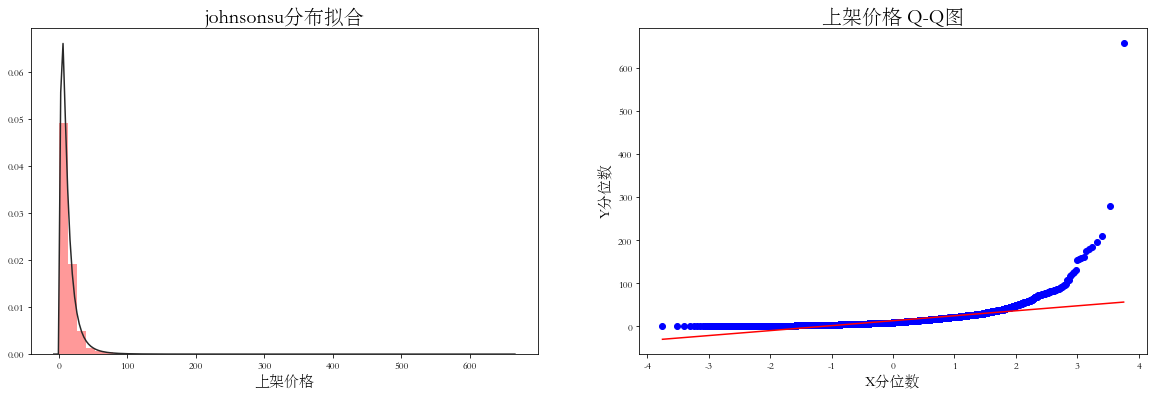

In [24]:
import scipy.stats as st
import seaborn as sns 
import matplotlib.pyplot as plt 

plt.figure(figsize=(20, 6))
d = df_train.rename(columns={'pushPrice':'上架价格'})
y = d['上架价格']

plt.subplot(121)
plt.title('johnsonsu分布拟合',fontsize=20)
plt.xlabel('上架价格',fontsize=15)
sns.distplot(y, kde=False, fit=st.johnsonsu, color='Red')

plt.subplot(122)
st.probplot(y, dist="norm", plot=plt)
plt.title('上架价格 Q-Q图',fontsize=20)
plt.xlabel('X分位数',fontsize=15)
plt.ylabel('Y分位数',fontsize=15)
plt.savefig('img/上架价格未转换前的分布.png',dpi=300)
plt.show()


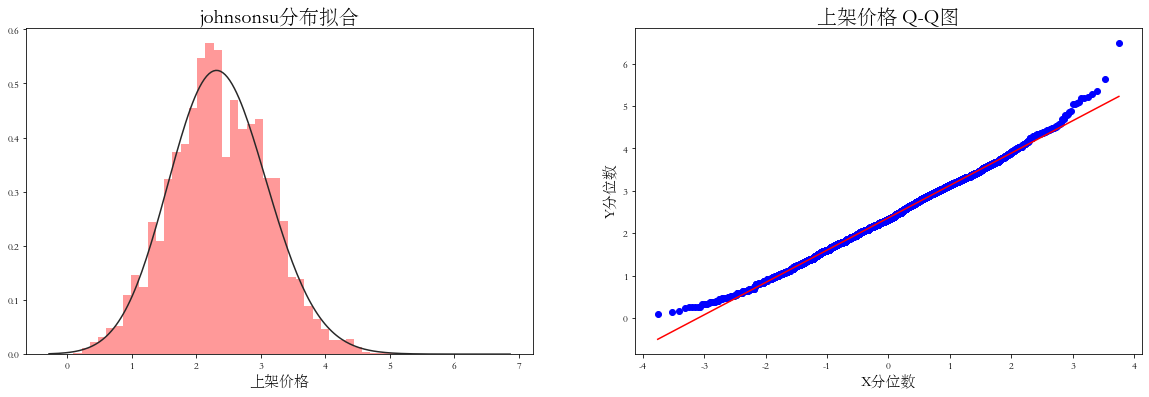

In [25]:
import scipy.stats as st
import seaborn as sns 
import matplotlib.pyplot as plt 

plt.figure(figsize=(20, 6))
d = df_train.rename(columns={'pushPrice':'上架价格'})
y = np.log1p(d['上架价格'])
plt.subplot(121)
plt.xlabel('上架价格',fontsize=15)
plt.title('johnsonsu分布拟合',fontsize=20)
sns.distplot(y, kde=False, fit=st.johnsonsu, color='Red')

plt.subplot(122)

st.probplot(y, dist="norm", plot=plt)
plt.title('上架价格 Q-Q图',fontsize=20)
plt.xlabel('X分位数',fontsize=15)
plt.ylabel('Y分位数',fontsize=15)
plt.savefig('img/价格转换后的分布.png',dpi=300)
plt.show()

## 1.7 提取时间特征

In [ ]:
# # 时间处理(提取年月日)
df_train['pushDate'] = pd.to_datetime(df_train['pushDate'])
df_test['pushDate'] = pd.to_datetime(df_test['pushDate'])
df_train['pushDate_year'] = df_train['pushDate'].dt.year
df_train['pushDate_month'] = df_train['pushDate'].dt.month
df_train['pushDate_day'] = df_train['pushDate'].dt.day

df_test['pushDate_year'] = df_test['pushDate'].dt.year
df_test['pushDate_month'] = df_test['pushDate'].dt.month
df_test['pushDate_day'] = df_test['pushDate'].dt.day

del df_train['pushDate']
del df_test['pushDate']


## 1.8 数据分布的转换

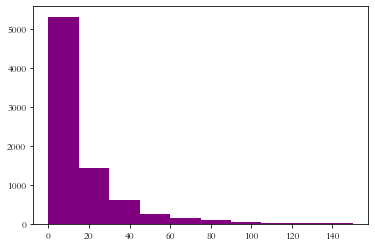

In [ ]:
# 插件价格分布，大于200的有20个，平均在75以下
y_p = df_train[df_train['transcycle'] <= 150]
## 3) 查看预测值的具体频数
plt.hist(y_p['transcycle'], orientation='vertical',
         histtype='bar', color='purple')
plt.show()


In [ ]:
df_train[df_train['transcycle'] <= 100].shape


(7883, 9)

In [ ]:
df_train[df_train['pushPrice'] < 150].shape


(7989, 9)

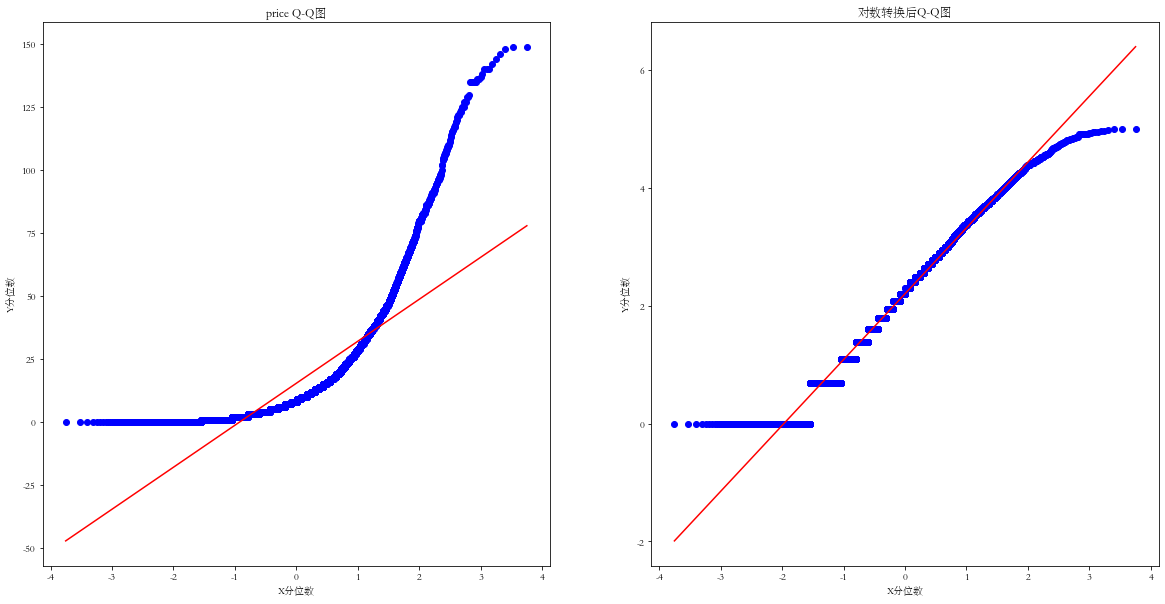

In [ ]:

#q-q 图是通过比较数据和正态分布的分位数是否相等来判断数据是不是符合正态分布

from sklearn.preprocessing import StandardScaler
scaler_trans = StandardScaler()

y = df_train[df_train['transcycle'] < 150]['transcycle']
plt.figure(figsize=(20, 10))
plt.subplot(121)
st.probplot(y, dist="norm", plot=plt)
plt.title('price Q-Q图')
plt.xlabel('X分位数')
plt.ylabel('Y分位数')

y2 = np.log1p(df_train[df_train['transcycle'] < 150]['transcycle'])
plt.subplot(122)
st.probplot(y2, dist="norm", plot=plt)
plt.title('对数转换后Q-Q图')
plt.xlabel('X分位数')
plt.ylabel('Y分位数')
# plt.savefig(
# '/media/mgege007/Compitition/MathorCup-Bigdata/复赛/IMG/数据分析/price正态检验Q-Q图.png')
plt.show()


In [ ]:
newcol = ['pushPrice', 'update_price', 'barging_times', 'barging_price','transcycle']

# df_train[newcol].to_csv('./data/clear_train_{}.csv'.format(len(newcol)-1), index=0)
# newcol.remove('transcycle')
# df_test[newcol].to_csv('./data/clear_test_{}.csv'.format(len(newcol)), index=0)


In [ ]:
mcorr = df_train.corr(method='spearman').abs()
relative_df = pd.DataFrame(mcorr['transcycle']).sort_values(by='transcycle', ascending=False)
# relative_df.to_csv('./submit/与交易周期相关性.csv',index=0)


## 1.8 特征交叉

In [ ]:
#定义交叉特征统计
def cross_cat_num(df, num_col, cat_col):
    for f1 in tqdm(cat_col):
        g = df.groupby(f1, as_index=False)
        for f2 in tqdm(num_col):
            feat = g[f2].agg({
                '{}_{}_max'.format(f1, f2): 'max', '{}_{}_min'.format(f1, f2): 'min',
                '{}_{}_median'.format(f1, f2): 'median',
                '{}_{}_sum'.format(f1, f2): 'sum',
                '{}_{}_mad'.format(f1, f2): 'mad',
            })
            df = df.merge(feat, on=f1, how='left')
    return(df)
### 用数值特征 与类别特征做交叉
cross_num = ['pushPrice','update_price','barging_price']

cross_cat = ['barging_times', 'pushDate_year', 'pushDate_month','pushDate_day']


In [ ]:
data_train = cross_cat_num(df_train, cross_num, cross_cat)  # 一阶交叉
data_test = cross_cat_num(df_test, cross_num, cross_cat)  # 一阶交叉

100%|██████████| 4/4 [00:00<00:00, 15.44it/s]


In [ ]:
data_train.shape


(8000, 69)

## 1.10 筛选与交易周期的关键因素

In [ ]:
mcorr = data_train.corr(method='spearman').abs()
trans_df = pd.DataFrame(mcorr['transcycle']).sort_values(by='transcycle',ascending=False)
trans_df

,transcycle
transcycle,1.000000
barging_times_barging_price_median,0.124195
update_price,0.124164
barging_times,0.124164
barging_times_update_price_median,0.124164
...,...
pushDate_month_update_price_median,NaN
pushDate_month_barging_price_median,NaN
pushDate_day_update_price_min,NaN
pushDate_day_update_price_median,NaN


In [ ]:
tt = mcorr['transcycle'] > 0
newcols = list(tt[tt == True].index)
len(newcols)


58

In [ ]:
data_train[newcols].to_csv(
    './data/clear_train_{}.csv'.format(len(newcols)-1), index=0)
newcols.remove('transcycle')
data_test[newcols].to_csv(
    './data/clear_test_{}.csv'.format(len(newcols)), index=0)
# data_train.to_csv(
#     './data/clear_train_{}.csv'.format(data_test.shape[1]), index=0)
# data_test.to_csv(
#     './data/clear_test_{}.csv'.format(data_test.shape[1]), index=0)


In [ ]:
data_test.shape[1]


27

# 2 模型训练

In [ ]:
from sklearn import metrics
from sklearn.model_selection import KFold
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import KFold
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler



In [ ]:

from sklearn.preprocessing import StandardScaler
train = pd.read_csv('./data/clear_train_28.csv')
test = pd.read_csv('./data/clear_test_28.csv')
train_X = train[train['pushPrice'] < 150]
# train_X['pushPrice'] = np.log1p(train_X['pushPrice'])
train_y = np.log1p(train_X['transcycle'])
del train_X['transcycle']
scaler = StandardScaler()
train_x = scaler.fit_transform(train_X)
test_x = scaler.fit_transform(test)


In [ ]:

train_y.shape


(7989,)

In [ ]:
from sklearn import metrics

params = {'learning_rate': 0.01,
          'boosting_type': 'gbdt',
          'objective': 'regression_l1',
          'metric': 'mae',
          'min_child_samples': 46,
          'min_child_weight': 0.01,
          'feature_fraction': 0.8,
          'bagging_fraction': 0.8,
          'bagging_freq': 2,
          'num_leaves': 32,
          'max_depth': 8,
          'n_jobs': -1,
          'seed': 2019,
          'verbose': -1,
          }

def MAE_metric(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred)


In [ ]:
folds = 5
kfold = KFold(n_splits=folds, shuffle=True, random_state=5421)
model_n = 'rf'
pred_list = []
all_val = []
for model_n in ['lgb','xgb','cat','knn','rf']:
    print("-------------正在训练{}----------".format(model_n))
    preds = np.zeros(len(test_x))
    fold_val = []
    for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        import lightgbm as lgb
        print('fold {}'.format(fold))
        x_tra, y_trn, x_val, y_val = train_x[trn_idx], train_y.iloc[trn_idx], train_x[val_idx], train_y.iloc[val_idx]

        train_set = lgb.Dataset(x_tra, y_trn)
        val_set = lgb.Dataset(x_val, y_val)
        # lgb
        if model_n =='lgb':
            model = lgb.train(params, train_set, num_boost_round=3000,
                                    valid_sets=(train_set, val_set),
                                    early_stopping_rounds=500,
                                    verbose_eval=False)
            val_pred = model.predict(x_val, predict_disable_shape_check=True)
            preds += model.predict(test_x,predict_disable_shape_check=True) / folds
        elif model_n =='xgb':
            model = xgb.XGBRegressor(
                objective='reg:squarederror',
                n_jobs=-1,
                n_estimators=1000,
                max_depth=7,
                subsample=0.8,
                learning_rate=0.05,
                gamma=0,
                colsample_bytree=0.9,
                random_state=2021, max_features=None, alpha=0.3)
            xgbmodel = model.fit(x_tra, y_trn, verbose=False)
            val_pred = xgbmodel.predict(x_val)
            preds += xgbmodel.predict(test_x,) / folds
        elif model_n =='cat':
            model = CatBoostRegressor(
                iterations=3000, learning_rate=0.03,
                depth=7,
                l2_leaf_reg=4,
                loss_function='MAE',
                eval_metric='MAE',
                random_seed=2021)
            val_pred = model.fit(x_tra, y_trn, verbose=False).predict(x_val)
            preds += model.predict(test_x,) / folds
        elif model_n =='knn':
            knnmodel = KNeighborsRegressor(n_neighbors=8).fit(x_tra, y_trn)
            val_pred = knnmodel.predict(x_val)
            preds += xgbmodel.predict(test_x,) / folds
        elif model_n =='rf':
            rfmodel = RandomForestRegressor(n_estimators=200).fit(x_tra, y_trn)
            val_pred = rfmodel.predict(x_val)
            preds += rfmodel.predict(test_x,) / folds
        
        val_mae = MAE_metric(y_val, val_pred)
        print('{} val_mae {}'.format(model_n,val_mae))
        fold_val.append(val_mae)
    all_val.append(fold_val)
    pred_list.append(list(preds))


-------------正在训练lgb----------
fold 0
lgb val_mae 0.9195445167153885
fold 1
lgb val_mae 0.8940499071836471
fold 2
lgb val_mae 0.8822967635992663
fold 3
lgb val_mae 0.903541160816376
fold 4
lgb val_mae 0.9109010097829437
-------------正在训练xgb----------
fold 0
xgb val_mae 0.9566159900659342
fold 1
xgb val_mae 0.9650012706589515
fold 2
xgb val_mae 0.9427056818727468
fold 3
xgb val_mae 0.9503711159685134
fold 4
xgb val_mae 0.968789448786576
-------------正在训练cat----------
fold 0
cat val_mae 0.9293971670194556
fold 1
cat val_mae 0.911942677659876
fold 2
cat val_mae 0.8952795469173933
fold 3
cat val_mae 0.9142579868837777
fold 4
cat val_mae 0.9258411818532728
-------------正在训练knn----------
fold 0
knn val_mae 0.9440156737661497
fold 1
knn val_mae 0.9180090381035809
fold 2
knn val_mae 0.9412759756954074
fold 3
knn val_mae 0.9313910034918231
fold 4
knn val_mae 0.943115669206743
-------------正在训练rf----------
fold 0


In [ ]:
val_df = pd.DataFrame(columns=['lgb', 'xgb', 'cat', 'knn', 'rf'])
val_df['lgb'] = all_val[0]
val_df['xgb'] = all_val[1]
val_df['cat'] = all_val[2]
val_df['knn'] = all_val[3]
val_df['rf'] = all_val[4]
val_df.to_csv('submit/fold_val_mae.csv',index=0)

In [ ]:
# 删除效果较差的XGB的数据
del pred_list[1]

In [ ]:
import math
file5 = pd.read_csv('./data/file5.csv')
submit_file  = pd.DataFrame(columns=['id'])
submit_file['id'] = file5['carid']
merge_list = list(np.sum(pred_list, axis=0)/len(pred_list))
# 向上取整
submit_file['transcycle'] = [math.ceil(i) for i in merge_list]
submit_file['transcycle'].astype(int)


0       14
1       16
2       15
3       17
4       15
        ..
1995    17
1996    21
1997    13
1998    13
1999    12
Name: transcycle, Length: 2000, dtype: int64

In [ ]:
with open('./submit/附件6：门店交易模型结果.txt','a+', encoding='utf-8') as f:
    for line in submit_file.values:
        f.write((str(line[0])+'\t'+str(line[1])+'\n'))
